In [9]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import pandas as pd

Load the CSV file and examine its contents

In [10]:
file_path = 'C:/Users/natha/OneDrive/Bureau/Interview trainings/Coding/Aquatic/Weather_Forecast_Ideas/data/chicago_beach_weather.csv'
weather_data = pd.read_csv(file_path)

weather_data.head()

,Station Name,Measurement Timestamp,Air Temperature
0,63rd Street Weather Station,01/01/2016 12:00:00 AM,-2.80
1,Oak Street Weather Station,01/01/2016 12:00:00 AM,-2.30
2,Foster Weather Station,01/01/2016 12:00:00 AM,-3.67
3,63rd Street Weather Station,01/01/2016 01:00:00 AM,-3.40
4,Foster Weather Station,01/01/2016 01:00:00 AM,-4.56


Process the data creating columns for each Stations

In [11]:
weather_data['Measurement Timestamp'] = pd.to_datetime(weather_data['Measurement Timestamp'])
weather_data.set_index('Measurement Timestamp', inplace=True)

df_pivot = weather_data.pivot(columns='Station Name', values='Air Temperature')
df_pivot = df_pivot.interpolate() #fillna(method='ffill').fillna(method='bfill')

df_pivot.head()

Station Name,63rd Street Weather Station,Foster Weather Station,Oak Street Weather Station
Measurement Timestamp,,,
2016-01-01 00:00:00,-2.8,-3.67,-2.3
2016-01-01 01:00:00,-3.4,-4.56,-3.2
2016-01-01 02:00:00,-4.2,-5.50,-4.0
2016-01-01 03:00:00,-5.1,-6.28,-4.8
2016-01-01 04:00:00,-5.7,-7.00,-5.5


Generate lagged features

In [12]:
station_names = df_pivot.columns
lagged_data = pd.DataFrame()

for station in station_names:
    for lag in range(1, 8):  # 7 lag days
        lagged_data[f'{station}_lag{lag}'] = df_pivot[station].shift(lag)

for station in station_names:
    lagged_data[f'target_{station}'] = df_pivot[station]

lagged_data = lagged_data.dropna()

In [13]:
station_names = df_pivot.columns
lagged_data = pd.DataFrame()

for station in station_names:
    for lag in range(1, 8):  # 7 hours lag (But you can try something else)
        lagged_data[f'{station}_lag{lag}'] = df_pivot[station].shift(lag)

for station in station_names:
    lagged_data[f'target_{station}'] = df_pivot[station]

lagged_data = lagged_data.dropna()

lagged_data.head()

,63rd Street Weather Station_lag1,63rd Street Weather Station_lag2,63rd Street Weather Station_lag3,63rd Street Weather Station_lag4,63rd Street Weather Station_lag5,63rd Street Weather Station_lag6,63rd Street Weather Station_lag7,Foster Weather Station_lag1,Foster Weather Station_lag2,Foster Weather Station_lag3,...,Oak Street Weather Station_lag1,Oak Street Weather Station_lag2,Oak Street Weather Station_lag3,Oak Street Weather Station_lag4,Oak Street Weather Station_lag5,Oak Street Weather Station_lag6,Oak Street Weather Station_lag7,target_63rd Street Weather Station,target_Foster Weather Station,target_Oak Street Weather Station
Measurement Timestamp,,,,,,,,,,,,,,,,,,,,,
2016-01-01 07:00:00,-5.8,-6.3,-5.7,-5.1,-4.2,-3.4,-2.8,-6.39,-7.06,-7.00,...,-5.2,-5.8,-5.5,-4.8,-4.0,-3.2,-2.3,-5.1,-5.67,-4.6
2016-01-01 08:00:00,-5.1,-5.8,-6.3,-5.7,-5.1,-4.2,-3.4,-5.67,-6.39,-7.06,...,-4.6,-5.2,-5.8,-5.5,-4.8,-4.0,-3.2,-4.3,-5.06,-3.8
2016-01-01 09:00:00,-4.3,-5.1,-5.8,-6.3,-5.7,-5.1,-4.2,-5.06,-5.67,-6.39,...,-3.8,-4.6,-5.2,-5.8,-5.5,-4.8,-4.0,-3.7,-4.39,-3.3
2016-01-01 10:00:00,-3.7,-4.3,-5.1,-5.8,-6.3,-5.7,-5.1,-4.39,-5.06,-5.67,...,-3.3,-3.8,-4.6,-5.2,-5.8,-5.5,-4.8,-3.3,-4.00,-2.7
2016-01-01 11:00:00,-3.3,-3.7,-4.3,-5.1,-5.8,-6.3,-5.7,-4.00,-4.39,-5.06,...,-2.7,-3.3,-3.8,-4.6,-5.2,-5.8,-5.5,-3.1,-3.56,-2.4


Let's play with Random Forest now!

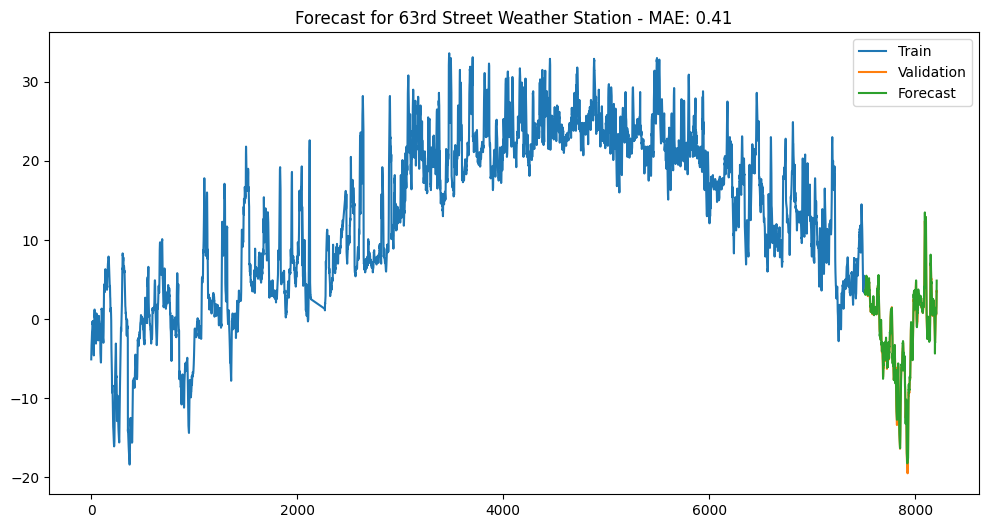

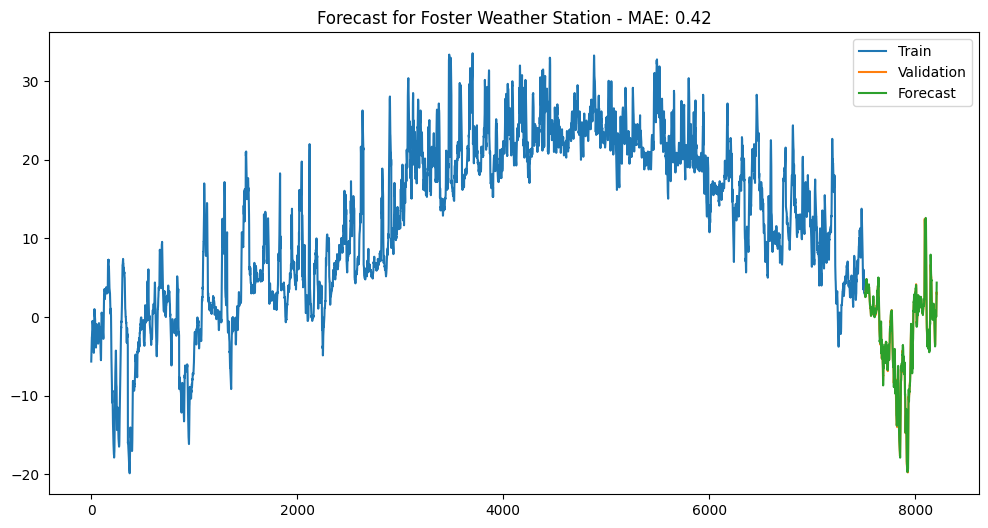

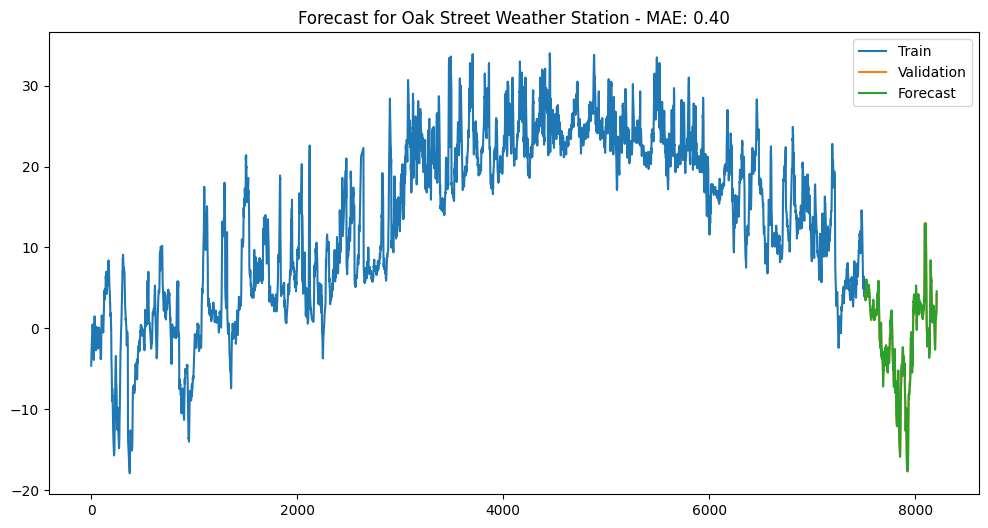

MAE scores for each station:
{'63rd Street Weather Station': 0.4084908954595955, 'Foster Weather Station': 0.42378805595408925, 'Oak Street Weather Station': 0.397745790961788}


In [14]:
# Split data into training (before December) and validation (December only)
train_data = lagged_data[lagged_data.index < '2016-12-01']
val_data = lagged_data[(lagged_data.index >= '2016-12-01') & (lagged_data.index <= '2016-12-31')]

mae_scores = {}
forecast_results = {}

for station in station_names:
    X_train = train_data.drop(columns=[f'target_{s}' for s in station_names])
    y_train = train_data[f'target_{station}']
    X_val = val_data.drop(columns=[f'target_{s}' for s in station_names])
    y_val = val_data[f'target_{station}']

    model = RandomForestRegressor(n_estimators=100) # You can try different hyperparameters
    model.fit(X_train, y_train)

    y_pred = model.predict(X_val)
    mae_scores[station] = mean_absolute_error(y_val, y_pred)

    forecast_results[station] = {
        'train': y_train,
        'validation': y_val,
        'forecast': y_pred
    }

for station in station_names:
    results = forecast_results[station]
    
    plt.figure(figsize=(12, 6))
    plt.plot(results['train'].values, label="Train")
    plt.plot(range(len(results['train']), len(results['train']) + len(results['validation'])), 
             results['validation'].values, label="Validation")
    plt.plot(range(len(results['train']), len(results['train']) + len(results['forecast'])), 
             results['forecast'], label="Forecast")
    plt.legend()
    plt.title(f"Forecast for {station} - MAE: {mae_scores[station]:.2f}")
    plt.show()

print("MAE scores for each station:")
print(mae_scores)

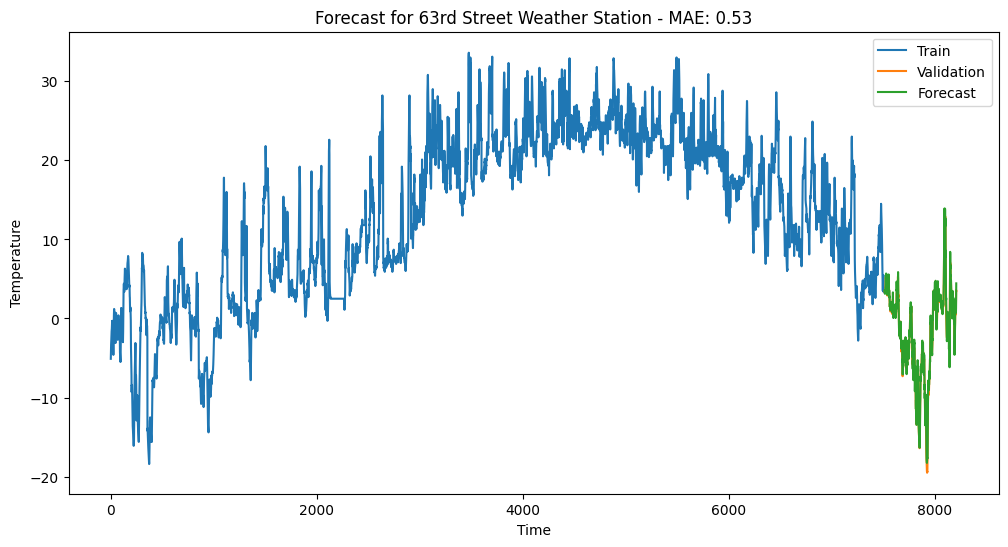

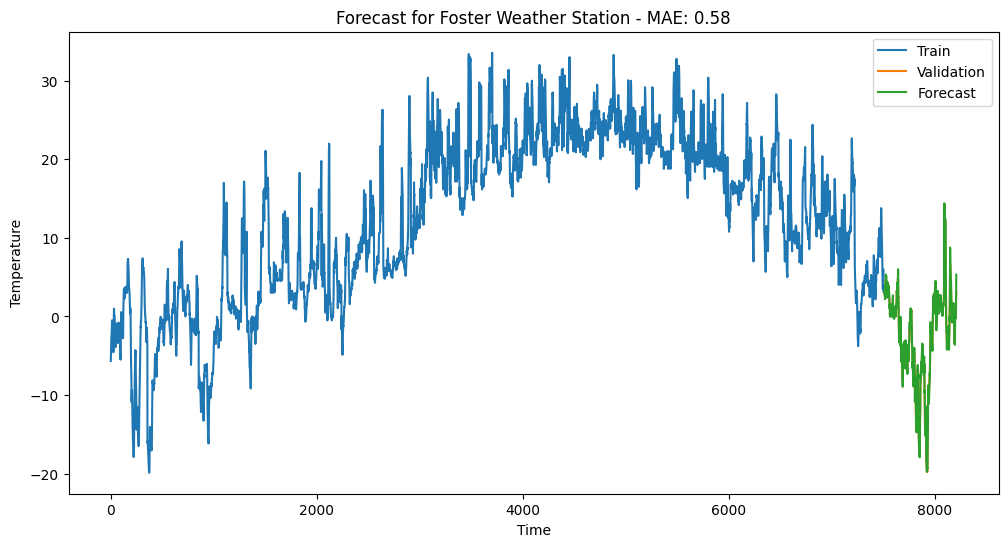

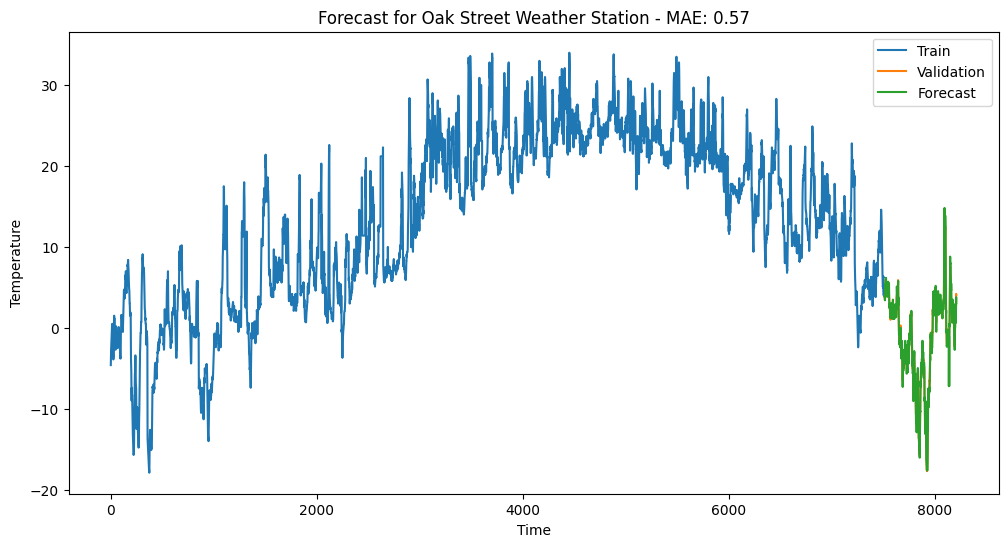

{'63rd Street Weather Station': 0.5269253945480628,
 'Foster Weather Station': 0.5772269727403152,
 'Oak Street Weather Station': 0.5669641319942614}

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import pandas as pd

# Load the CSV file to examine its contents
file_path = 'C:/Users/natha/OneDrive/Bureau/Interview trainings/Coding/Aquatic/Weather_Forecast_Ideas/data/chicago_beach_weather.csv'
weather_data = pd.read_csv(file_path)

# Display the first few rows of the data to understand its structure
weather_data.head()

# Preprocess the data as required
weather_data['Measurement Timestamp'] = pd.to_datetime(weather_data['Measurement Timestamp'])
weather_data.set_index('Measurement Timestamp', inplace=True)

# Pivot the data by station name and fill any missing values
df_pivot = weather_data.pivot(columns='Station Name', values='Air Temperature')
df_pivot = df_pivot.fillna(method='ffill').fillna(method='bfill')

# Generate lagged features
station_names = df_pivot.columns
lagged_data = pd.DataFrame()

# Create lagged features for each station
for station in station_names:
    for lag in range(1, 8):  # 7 hours lag
        lagged_data[f'{station}_lag{lag}'] = df_pivot[station].shift(lag)

# Add each station's current value as a target
for station in station_names:
    lagged_data[f'target_{station}'] = df_pivot[station]

# Drop rows with NaN values after creating lags
lagged_data = lagged_data.dropna()

# Split data into training (before December) and validation (December only)
train_data = lagged_data[lagged_data.index < '2016-12-01']
val_data = lagged_data[(lagged_data.index >= '2016-12-01') & (lagged_data.index <= '2016-12-31')]

# Dictionary to store results for each station
mae_scores = {}
forecast_results = {}

# Train and predict for each station
for station in station_names:
    # Define X and y for the current station
    X_train = train_data.drop(columns=[f'target_{s}' for s in station_names])
    y_train = train_data[f'target_{station}']
    X_val = val_data.drop(columns=[f'target_{s}' for s in station_names])
    y_val = val_data[f'target_{station}']

    # Train the Random Forest model
    model = RandomForestRegressor(n_estimators=100, random_state=123)
    model.fit(X_train, y_train)

    # Predict and compute MAE for validation set
    y_pred = model.predict(X_val)
    mae_scores[station] = mean_absolute_error(y_val, y_pred)

    # Store the forecast, validation, and training sets for plotting
    forecast_results[station] = {
        'train': y_train,
        'validation': y_val,
        'forecast': y_pred
    }

# Plot the forecast, validation, and training sets for each station
for station in station_names:
    results = forecast_results[station]
    
    plt.figure(figsize=(12, 6))
    plt.plot(results['train'].values, label="Train")
    plt.plot(range(len(results['train']), len(results['train']) + len(results['validation'])), 
             results['validation'].values, label="Validation")
    plt.plot(range(len(results['train']), len(results['train']) + len(results['forecast'])), 
             results['forecast'], label="Forecast")
    plt.legend()
    plt.title(f"Forecast for {station} - MAE: {mae_scores[station]:.2f}")
    plt.xlabel("Time")
    plt.ylabel("Temperature")
    plt.show()

# Display MAE scores for each station
mae_scores

In [9]:
!pip install --upgrade pip
!pip install skopt


Defaulting to user installation because normal site-packages is not writeable
  Using cached pip-24.3.1-py3-none-any.whl.metadata (3.7 kB)
Using cached pip-24.3.1-py3-none-any.whl (1.8 MB)


ERROR: To modify pip, please run the following command:
c:\program files\python38\python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable


ERROR: Could not find a version that satisfies the requirement skopt (from versions: none)
ERROR: No matching distribution found for skopt

[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


# GridSearch

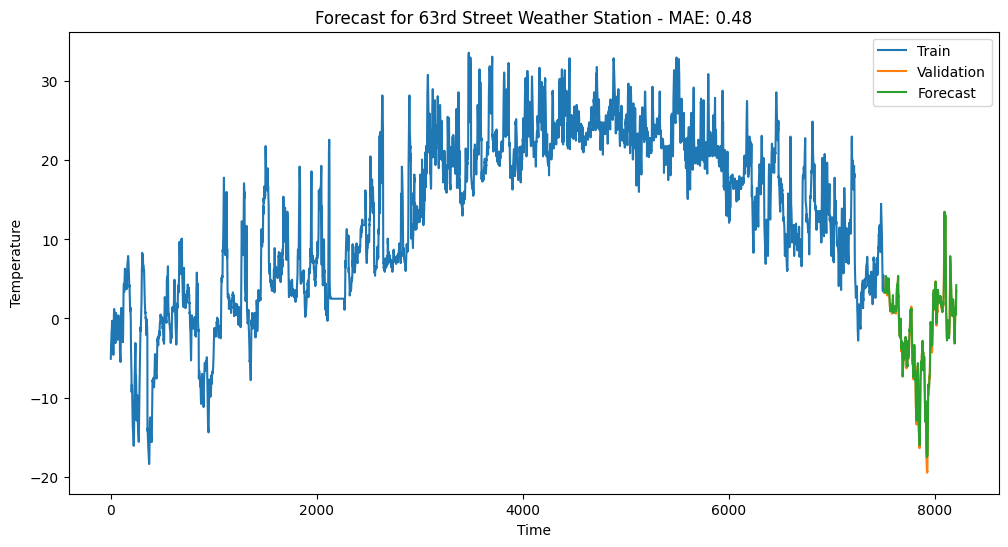

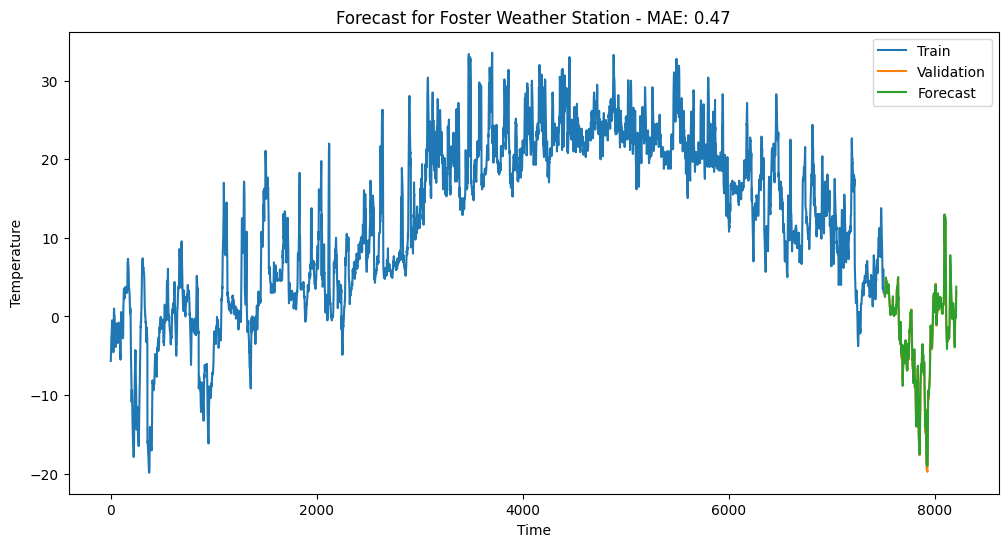

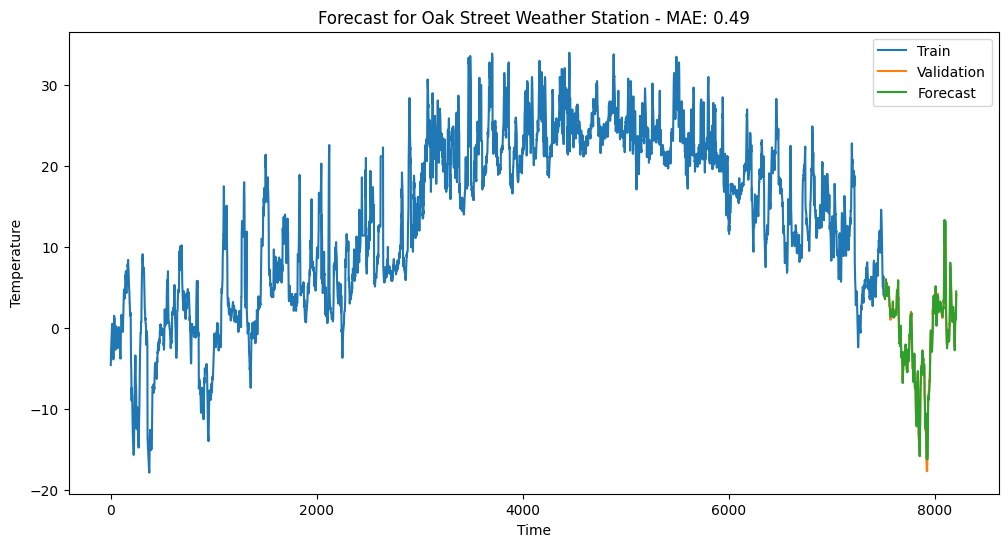

MAE Scores per Station: {'63rd Street Weather Station': 0.4769812844739709, 'Foster Weather Station': 0.47001962050314217, 'Oak Street Weather Station': 0.4920334304395845}
Best Parameters per Station: {'63rd Street Weather Station': {'n_estimators': 150, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_samples': 0.9, 'max_features': 'sqrt', 'max_depth': None}, 'Foster Weather Station': {'n_estimators': 50, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_samples': 0.9, 'max_features': 'sqrt', 'max_depth': 20}, 'Oak Street Weather Station': {'n_estimators': 150, 'min_samples_split': 5, 'min_samples_leaf': 8, 'max_samples': 0.8, 'max_features': 'sqrt', 'max_depth': 20}}


In [11]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
import numpy as np

# Load the CSV file
file_path = 'C:/Users/natha/OneDrive/Bureau/Interview trainings/Coding/Aquatic/Weather_Forecast_Ideas/data/chicago_beach_weather.csv'
weather_data = pd.read_csv(file_path)

# Preprocess the data
weather_data['Measurement Timestamp'] = pd.to_datetime(weather_data['Measurement Timestamp'])
weather_data.set_index('Measurement Timestamp', inplace=True)

# Pivot the data by station name and fill any missing values
df_pivot = weather_data.pivot(columns='Station Name', values='Air Temperature')
df_pivot = df_pivot.fillna(method='ffill').fillna(method='bfill')

# Generate lagged features
station_names = df_pivot.columns
lagged_data = pd.DataFrame()

# Create lagged features for each station
for station in station_names:
    for lag in range(1, 8):  # 7 hours lag
        lagged_data[f'{station}_lag{lag}'] = df_pivot[station].shift(lag)

# Add each station's current value as a target
for station in station_names:
    lagged_data[f'target_{station}'] = df_pivot[station]

# Drop rows with NaN values after creating lags
lagged_data = lagged_data.dropna()

# Split data into training (before December) and validation (December only)
train_data = lagged_data[lagged_data.index < '2016-12-01']
val_data = lagged_data[(lagged_data.index >= '2016-12-01') & (lagged_data.index <= '2016-12-31')]

# Define the parameter grid for hyperparameter optimization
param_dist = {
    'n_estimators': np.arange(50, 201, 50),  # Try 50, 100, 150, 200
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 4, 8],
    'max_features': ['sqrt', 'log2'],
    'max_samples': [0.8, 0.9, 1.0]
}

# Dictionary to store results for each station
best_params = {}
mae_scores = {}
forecast_results = {}

# Use a time series split for cross-validation to preserve the temporal order
tscv = TimeSeriesSplit(n_splits=5)

# Train and predict for each station
for station in station_names:
    X_train = train_data.drop(columns=[f'target_{s}' for s in station_names])
    y_train = train_data[f'target_{station}']
    X_val = val_data.drop(columns=[f'target_{s}' for s in station_names])
    y_val = val_data[f'target_{station}']
    
    # Perform random search with cross-validation
    random_search = RandomizedSearchCV(
        RandomForestRegressor(random_state=123, oob_score=True),
        param_distributions=param_dist,
        n_iter=30,  # Number of parameter settings to sample
        cv=tscv,
        scoring='neg_mean_absolute_error',
        random_state=123
    )
    random_search.fit(X_train, y_train)
    
    # Train the final model using the best parameters
    best_station_params = random_search.best_params_
    best_model = RandomForestRegressor(**best_station_params, random_state=123, oob_score=True)
    best_model.fit(X_train, y_train)
    
    # Predict and compute MAE for the validation set
    y_pred = best_model.predict(X_val)
    mae_scores[station] = mean_absolute_error(y_val, y_pred)
    best_params[station] = best_station_params
    
    # Store the forecast, validation, and training sets for plotting
    forecast_results[station] = {
        'train': y_train,
        'validation': y_val,
        'forecast': y_pred
    }

# Plot the forecast, validation, and training sets for each station
for station in station_names:
    results = forecast_results[station]
    
    plt.figure(figsize=(12, 6))
    plt.plot(results['train'].values, label="Train")
    plt.plot(range(len(results['train']), len(results['train']) + len(results['validation'])), 
             results['validation'].values, label="Validation")
    plt.plot(range(len(results['train']), len(results['train']) + len(results['forecast'])), 
             results['forecast'], label="Forecast")
    plt.legend()
    plt.title(f"Forecast for {station} - MAE: {mae_scores[station]:.2f}")
    plt.xlabel("Time")
    plt.ylabel("Temperature")
    plt.show()

# Display MAE scores and best parameters for each station
print("MAE Scores per Station:", mae_scores)
print("Best Parameters per Station:", best_params)


# UQ with ensemble of trees

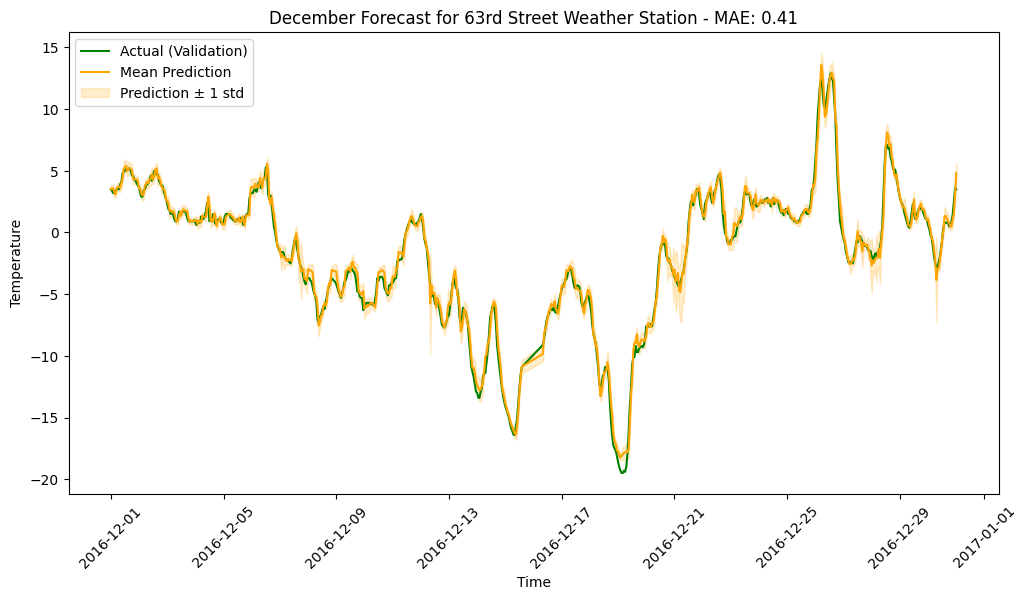

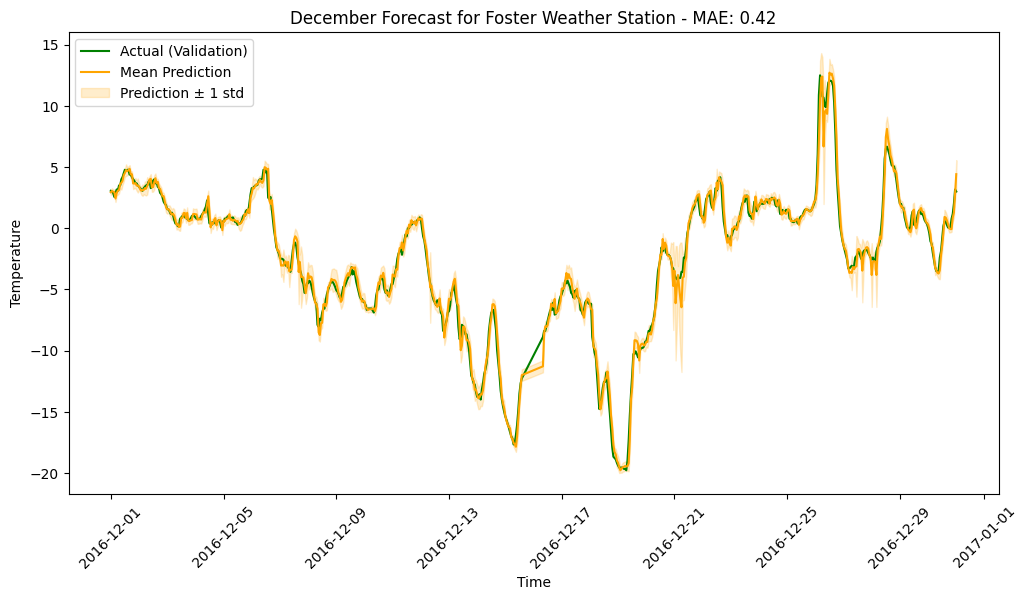

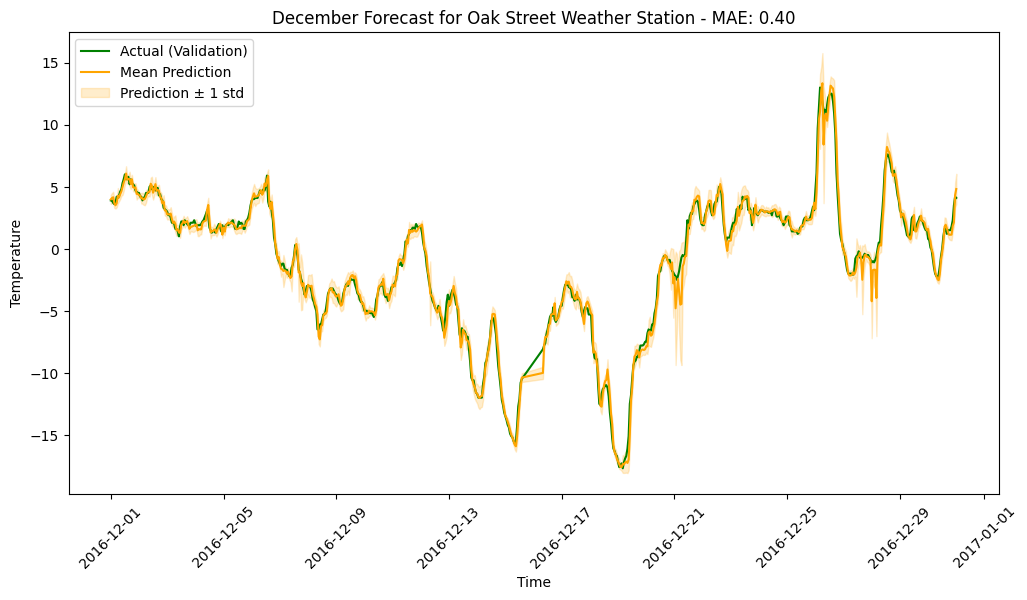

MAE Scores per Station: {'63rd Street Weather Station': 0.40794548063127645, 'Foster Weather Station': 0.41626714490674327, 'Oak Street Weather Station': 0.40277044476327123}


In [18]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Load the CSV file
file_path = 'C:/Users/natha/OneDrive/Bureau/Interview trainings/Coding/Aquatic/Weather_Forecast_Ideas/data/chicago_beach_weather.csv'
weather_data = pd.read_csv(file_path)

# Preprocess the data
weather_data['Measurement Timestamp'] = pd.to_datetime(weather_data['Measurement Timestamp'])
weather_data.set_index('Measurement Timestamp', inplace=True)

# Pivot the data by station name and fill any missing values
df_pivot = weather_data.pivot(columns='Station Name', values='Air Temperature')
df_pivot = df_pivot.fillna(method='ffill').fillna(method='bfill')

# Generate lagged features
station_names = df_pivot.columns
lagged_data = pd.DataFrame()

# Create lagged features for each station
for station in station_names:
    for lag in range(1, 8):  # 7 hours lag
        lagged_data[f'{station}_lag{lag}'] = df_pivot[station].shift(lag)

# Add each station's current value as a target
for station in station_names:
    lagged_data[f'target_{station}'] = df_pivot[station]

# Drop rows with NaN values after creating lags
lagged_data = lagged_data.dropna()

# Split data into training (before December) and validation (December only)
train_data = lagged_data[lagged_data.index < '2016-12-01']
val_data = lagged_data[(lagged_data.index >= '2016-12-01') & (lagged_data.index <= '2016-12-31')]

# Dictionary to store results for each station
mae_scores = {}
forecast_results = {}

# Train and predict for each station
for station in station_names:
    X_train = train_data.drop(columns=[f'target_{s}' for s in station_names])
    y_train = train_data[f'target_{station}']
    X_val = val_data.drop(columns=[f'target_{s}' for s in station_names])
    y_val = val_data[f'target_{station}']
    
    # Train a single RandomForestRegressor model with predefined parameters
    model = RandomForestRegressor(n_estimators=100, random_state=123) #max_depth=10, min_samples_split=5, min_samples_leaf=2, max_features='sqrt', , oob_score=True
                                  
    model.fit(X_train, y_train)
    
    # Get predictions from each tree in the forest for the validation set
    all_tree_predictions = np.array([tree.predict(X_val.values) for tree in model.estimators_])

    # Calculate mean and standard deviation of predictions across all trees
    mean_predictions = np.mean(all_tree_predictions, axis=0)
    std_predictions = np.std(all_tree_predictions, axis=0)

    # Compute MAE for the mean predictions
    mae_scores[station] = mean_absolute_error(y_val, mean_predictions)
    
    # Store the forecast, validation, and training sets for plotting
    forecast_results[station] = {
        'validation': y_val,
        'forecast': mean_predictions,
        'std': std_predictions
    }

# Plot only the December forecast with uncertainty band for each station
for station in station_names:
    results = forecast_results[station]
    
    plt.figure(figsize=(12, 6))
    plt.plot(results['validation'].index, results['validation'].values, label="Actual (Validation)", color="green")
    plt.plot(results['validation'].index, results['forecast'], label="Mean Prediction", color="orange")
    plt.fill_between(results['validation'].index, 
                     results['forecast'] - results['std'], 
                     results['forecast'] + results['std'], 
                     color="orange", alpha=0.2, label="Prediction ± 1 std")
    plt.legend()
    plt.title(f"December Forecast for {station} - MAE: {mae_scores[station]:.2f}")
    plt.xlabel("Time")
    plt.ylabel("Temperature")
    plt.xticks(rotation=45)
    plt.show()

# Display MAE scores for each station
print("MAE Scores per Station:", mae_scores)
